In [1]:
import os 
os.chdir("..")

%load_ext autoreload
%autoreload 2

In [122]:

import numpy as np
import matplotlib.pyplot as plt
from numerics.utilities.misc import *
from analysis.stopping_time import *
import matplotlib
from scipy.linalg import solve_continuous_are

from tqdm import tqdm

In [123]:
params, exp_path = def_params(flip = 0)

damping = params[1][0]
total_time = 200.*damping
dt = damping/1e3

In [124]:
N = int(1e4)

In [125]:
timind, indis = get_timind_indis(total_time, dt)


In [128]:
l = load_data(exp_path = exp_path ,itraj=1, total_time=total_time, dt=dt)
timind, indis = get_timind_indis(total_time, dt)

r0, r1 = load_liks(itraj=1, total_time=total_time, dt=dt)


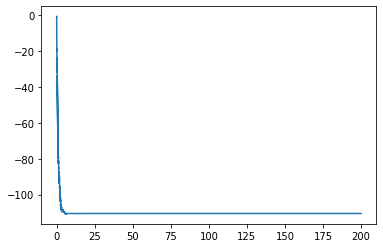

In [129]:
plt.plot(timind, r1-r0)

In [119]:
[kappa1, eta1, omega1, xi1], [kappa0, eta0, omega0, xi0]  = params
model_cte = np.sqrt(2) ### measurement model


def give_matrices(kappa, eta, omega, xi):
    A = np.array([[-kappa/2 -xi, omega],[-omega, xi -kappa/2]])
    B = E = -np.sqrt(eta*kappa)*np.array([[1.,0.],[0.,1.]]) #homodyne
    D = np.diag([1.2*kappa]*2)
    C = -B.T
    G = E.T
    return A, C, D,G

A1, C1, D1, G1 = give_matrices(kappa1, eta1, omega1, 0.)
A0, C0, D0, G0 = give_matrices(kappa0, eta0, omega0, xi0)

In [120]:
sst1 = solve_continuous_are( (A1-np.dot(G1.T,C1)).T, C1.T, D1 - np.dot(G1.T, G1), np.eye(2)) #### A.T because the way it's implemented!


In [121]:
sst1

array([[1.17082039e+00, 4.77486952e-16],
       [4.77486952e-16, 1.17082039e+00]])

In [76]:
xi1

0.0

In [36]:
[kappa1, eta1, omega1, xi1],

([1.0, 1.0, 0.2, 0.0],)

In [7]:
rr1 = []
for itraj in range(1,10):
    r1, r0 = load_liks(itraj=itraj, total_time=total_time, dt=dt)
    rr1.append(r1)


In [30]:
Ntraj = 2000
B = 6.
dB = .25
boundsB= np.arange(-B,B+dB,dB)

stop = {}
stop["_0"] = {i:[] for i in range(1,Ntraj)}
stop["_1"] = {i:[] for i in range(1,Ntraj)}


er=[]
deter = {}
deter["h0/h1"] ={indb:[0]*len(indis) for indb in range(len(boundsB))}
deter["h1/h0"] = {indb:[0]*len(indis) for indb in range(len(boundsB))}

l0,l1 = np.zeros((2,len(timind)))

deter_data_h0_h1 = np.zeros((Ntraj, len(boundsB), len(indis)))
deter_data_h1_h0 = np.zeros((Ntraj, len(boundsB), len(indis)))

intindis = np.arange(0,len(indis))

n=1
ers = []
for itraj in tqdm(range(1,Ntraj)):
    try:

        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, total_time=total_time, dt=dt)
        for indb,b in enumerate(boundsB):
            if b>=0:
                stop["_1"][itraj].append(get_stop_time(log_lik_ratio, b, timind))
                stop["_0"][itraj].append(get_stop_time(log_lik_ratio_swap, b,timind))

                deter["h0/h1"][indb] += ((log_lik_ratio[intindis] < b).astype(int)  - deter["h0/h1"][indb])/n
                deter["h1/h0"][indb] += ((log_lik_ratio_swap[intindis] < b).astype(int)  - deter["h1/h0"][indb])/n

        l1= l1 + log_lik_ratio
        l0 = l0 +log_lik_ratio_swap
        n+=1
    except Exception:
       ers.append(itraj)
l0/=(Ntraj - len(ers))
l1/=(Ntraj - len(ers))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1999/1999 [00:06<00:00, 293.29it/s]


In [31]:

alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)

bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)

times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]


stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

avg_times = 0.5*(avg_times0 + avg_times1)

stoch = avg_times

avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

/tmp/ipykernel_3060468/1808186652.py:10: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
/tmp/ipykernel_3060468/1808186652.py:44: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


In [32]:
cons1, cons0 = [], []
anals1, anals0 = [], []
timbin0, timbin1 = [], []
for indb, b in enumerate(bpos):
    counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
    counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)
    
    timms1 = np.linspace(0,np.max(bins1), 100)
    timms0 = np.linspace(0,np.max(bins0), 100)
    
    timbins1 = .5*(bins1[1:] + bins1[:-1])
    timbins0 = .5*(bins0[1:] + bins0[:-1])
    
    cons1.append(counts1)
    cons0.append(counts0)
    
    timbin1.append(timbins1)
    timbin0.append(timbins0)
    

/tmp/ipykernel_3060468/4020109435.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts1, bins1 = np.histogram(stops1[indb], 50, normed=True)
/tmp/ipykernel_3060468/4020109435.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts0, bins0 = np.histogram(stops0[indb], 50, normed=True)


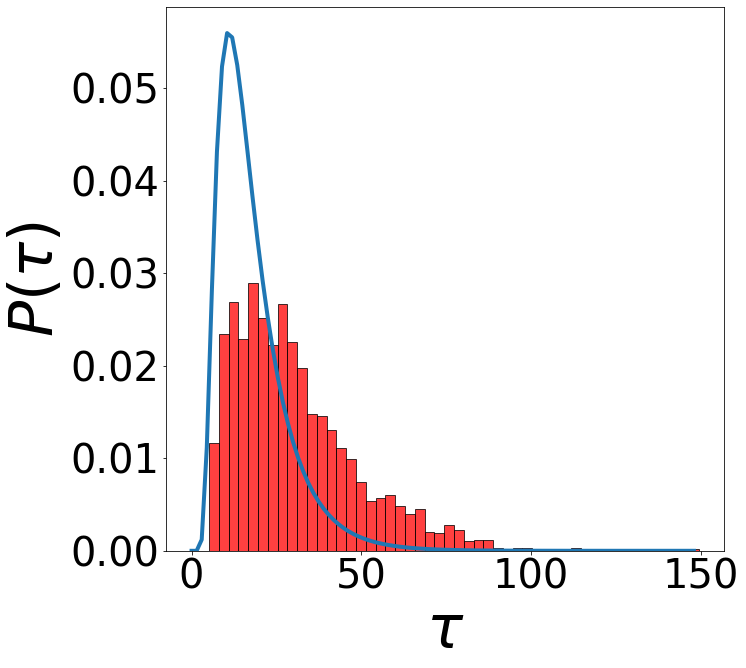

In [68]:
def prob_craft(t, b, mu):
    
    S= np.sqrt(2*mu)

    div = (np.sqrt(2*np.pi)*S*(t**(3/2)))
    return  abs(b)*np.exp(-((abs(b)-mu*t)**2)/(2*t*(S**2)))/div


muu = l1[-1]/timind[-1]

LS, TS = 60, 40
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
indb = -1

timm =  np.linspace(np.min(timbin1),np.max(timbin1),100)

popo = [prob_craft(tt, bpos[indb] , muu) for tt in timm]
ax.plot(timm,popo, linewidth=4)
ax.bar(timbin1[indb], cons1[indb], width=timbin1[indb][1]-timbin1[indb][0], color="red", alpha=0.75, edgecolor="black",)#, label="simulations")
ax.set_xlabel(r'$\tau$',size=LS)
ax.set_ylabel(r'$P(\tau)$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)

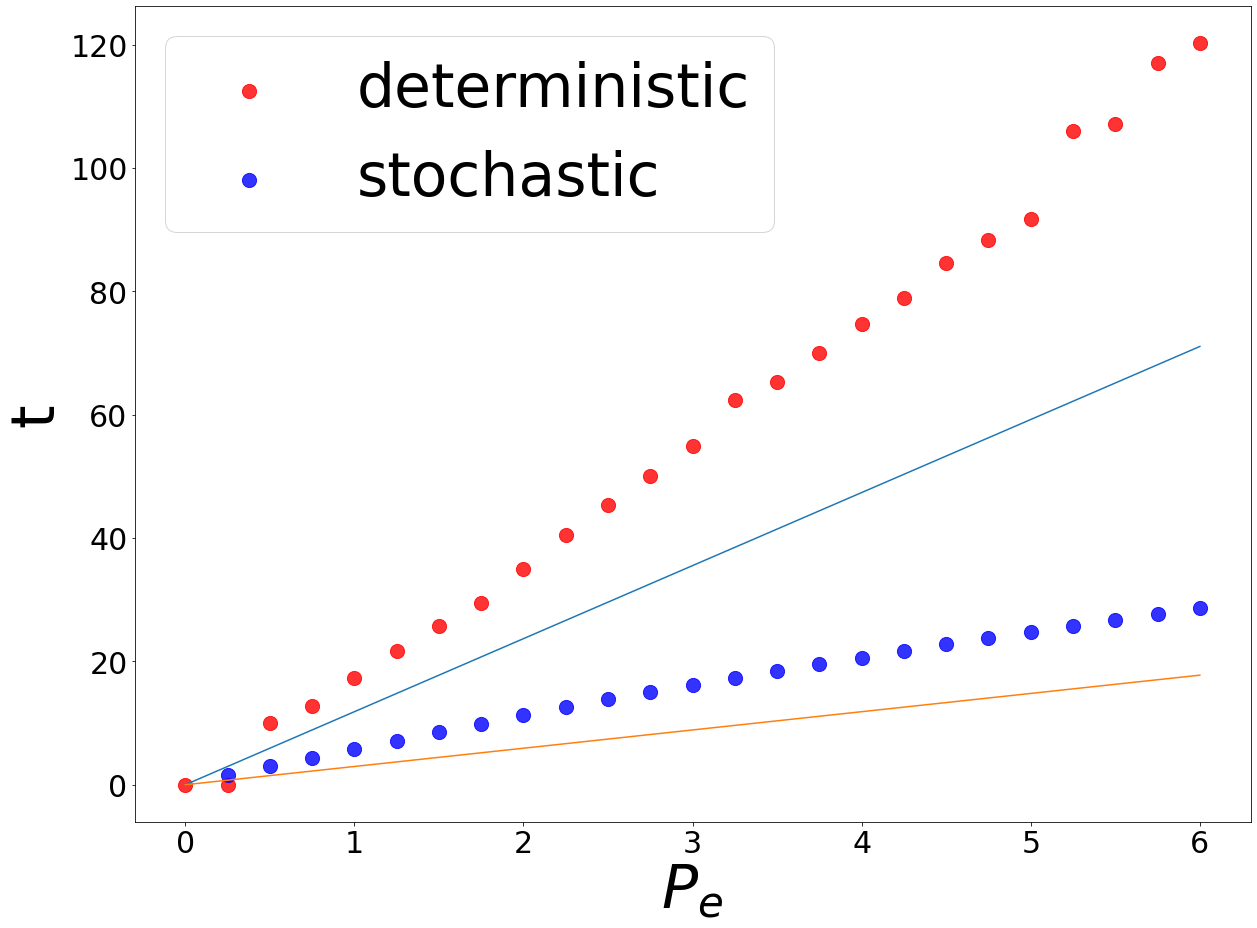

In [39]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
mm = l1[-1]/timind[-1]

ax.scatter(bpos, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(bpos, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")
ax.plot(bpos, 4*bpos/mm)
ax.plot(bpos, bpos/mm)

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
#ax.set_xscale("log")
#ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




In [40]:
#with open(path_data+"stop.pickle","rb") as f:
 #   stop = pickle.load( f)#, protocol=pickle.HIGHEST_PROTOCOL)

#with open(path_data+"deter.pickle","rb") as f:
#    deter = pickle.load(f)#, protocol=pickle.HIGHEST_PROTOCOL)
    
alphas = list(deter["h0/h1"].values())
betas = list(deter["h1/h0"].values())

alphas = np.stack(alphas)
betas = np.stack(betas)




bpos = boundsB[boundsB>=0]
bneg = boundsB[boundsB<0]

avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
avg_err_beta = lambda o :(1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))

errs = np.array([avg_err_alpha(b) for b in boundsB]) #
tot_err = 0.5*(alphas+betas)#0.5*(alphas + betas)
times_to_errs = [timind[np.argmin(np.abs(tot_err[indb,:] - errs[indb]))] for indb in range(len(bpos))]



stops0 = [[] for k in range(len(bpos))]
stops1 = [[] for k in range(len(bpos))]

values1 = list(stop["_1"].values())
values0 = list(stop["_0"].values())
for k,val in enumerate(values1):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values1[k][indb]])[0] == True:
                stops1[indb].append(np.squeeze(values1[k][indb]))
        
for k,val in enumerate(values0):
    if len(val)!=0:
        for indb in range(len(val)):
            if ~np.isnan([values0[k][indb]])[0] == True:
                stops0[indb].append(np.squeeze(values0[k][indb]))


avg_times1 = np.array([np.mean(k) for k in stops1])
avg_times0 = np.array([np.mean(k) for k in stops0])

std_times1 = np.array([np.std(k) for k in stops1])
std_times0 = np.array([np.std(k) for k in stops0])
avg_times = 0.5*(avg_times0 + avg_times1)

stoch = avg_times

avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))
errs = [avg_err_alpha(b) for b in bpos]
times_alpha_to_errB = [timind[np.argmin(np.abs(alphas[indb+len(bneg),:]+betas[len(bneg)-indb+1,:] - errs[indb]))] for indb in range(len(bpos))]

/tmp/ipykernel_3060468/2764343774.py:19: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-abs(o)))/(np.exp(abs(o)) - np.exp(-abs(o)))
/home/giq/.local/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/giq/.local/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/giq/.local/lib/python3.10/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_3060468/2764343774.py:55: RuntimeWarning: invalid value encountered in double_scalars
  avg_err_alpha = lambda o: (1-np.exp(-o))/(np.exp(o) - np.exp(-o))


Text(0, 0.5, '$\\frac{t_{det}}{t_{stoch}}$')

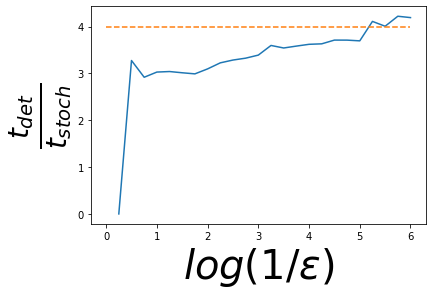

In [41]:
plt.plot(bpos,(times_alpha_to_errB/stoch)[-30:])
plt.plot(bpos,4*np.ones(len(stoch)),'--')
plt.xlabel(r'$log(1/\epsilon)$', size=40)
plt.ylabel(r'$\frac{t_{det}}{t_{stoch}}$', size=40)

In [42]:

fig = plt.figure(figsize=(20,15))
ax = plt.subplot(111)
lw=10
TS=30
ax.scatter(errs, times_alpha_to_errB,color="red", alpha=0.8,s=200, label="deterministic")
ax.scatter(errs, stoch ,color="blue",s=200,  alpha=0.8,label="stochastic")

#ax.fill_between(errs, stoch - stoch_std/2, stoch + stoch_std/2, alpha=0.5, color="blue")
ax.set_xticks([np.round(k,2) for k in np.linspace(min(errs),max(errs),4)])
ax.set_xlabel(r'$P_e$', size=LS)
ax.tick_params(axis='both', which='major', labelsize=TS)
ax.set_ylabel("t", size=LS)
ax.legend(prop={"size":LS})
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
#plt.savefig(plotdir+"freq_adaptive_vs_det.pdf")




ValueError: cannot convert float NaN to integer

<Figure size 1440x1080 with 1 Axes>

In [45]:
l1s, l0s = [], []
for itraj in tqdm(range(1,5*10**3)):
    try:
        
        log_lik_ratio, log_lik_ratio_swap = load_liks(itraj=itraj, dt=dt, total_time=total_time)
        l1s.append(log_lik_ratio)#append([log_lik_ratio[k] for k in indis])
        l0s.append(log_lik_ratio_swap) #[k] for k in indis])
    except Exception:
        pass

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4999/4999 [00:01<00:00, 3676.91it/s]


In [46]:
mss = np.mean(l1s,axis=0)
sss = np.std(l1s,axis=0)

In [47]:
ss = np.zeros(len(l1s[0]))
for l in l1s:
    ss+= l**2

In [48]:
l2 = ss/len(l1s)

/tmp/ipykernel_3060468/1751569385.py:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(timind,mss**2/l2)#mss**2/(sss**2 + mss**2))


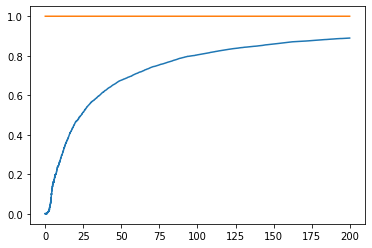

In [51]:
plt.plot(timind,mss**2/l2)#mss**2/(sss**2 + mss**2))
plt.plot(timind, np.ones(len(timind)))

In [53]:
def fun(ell,x):
    return (1/np.sqrt(4*np.pi*ell))*np.exp((-(x-ell)**2)/(4*ell))

In [65]:
l1s = np.stack(l1s)
l0s = np.stack(l0s)

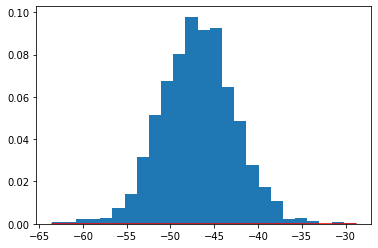

In [67]:
indi = -1
timi = timind[indi]
muLF = -l0[indi]/timind[indi]
counts, bins, ploo = plt.hist(l0s[:,indi], bins=25, density=True)
xx = np.linspace(min(bins),max(bins),1000)
ff = [fun(l1[indi], x) for x in xx]
plt.plot(xx,ff, color="red")